# LAB 7: Error analysis

Objectives
* Construct a  linear text classifier using SGDClassifier
* Evaluate its performance and categorize the errors that it makes
* Eaxmine model's coefficients and decision function values
* Interpret model results using LIME

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [2]:
train = pd.read_parquet("s3://ling583/lab7-train.parquet", storage_options={"anon":True})
test = pd.read_parquet("s3://ling583/lab7-test.parquet", storage_options={"anon":True})

In [3]:
import cloudpickle
from sklearn.metrics import classification_report, f1_score, plot_confusion_matrix

In [4]:
sgd = cloudpickle.load(open("sgd.model", "rb"))

In [5]:
predicted = sgd.predict(test["text"])
print(classification_report(test["topics"], predicted))

              precision    recall  f1-score   support

        GJOB       0.98      0.93      0.95       573
        GPOL       0.94      0.96      0.95      1853
        GSPO       1.00      0.99      1.00      1410
        GVIO       0.92      0.91      0.92       928

    accuracy                           0.96      4764
   macro avg       0.96      0.95      0.95      4764
weighted avg       0.96      0.96      0.96      4764



---

## Decision function

In [6]:
labels = sgd.named_steps['sgdclassifier'].classes_
scores = sgd.decision_function(test["text"])

In [7]:
labels

array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4')

In [8]:
scores[0,:]

array([ 0.01040488, -0.82868882, -0.98145051, -0.95546065])

In [9]:
test['topics'].iloc[0]

'GJOB'

In [10]:
test['text'].iloc[0]

"Canada's Terra Nova partners set labor agreement. A new labor agreement covering future operations at Newfoundland's Bull Arm construction site, where some work on the Terra Nova oil project is expected to be done, was completed on Monday, Terra Nova's partners said. The deal, signed by PCL Industrial Constructors Inc and the Newfoundland and Labrador Building and Construction Trades Council, will allow Bull Arm to be considered for the building of some of the oil platform's topsides. The key part of the deal was the formation of a single union representing workers at the site, the firms said."

In [11]:
highest = scores.max(axis=1)

In [12]:
highest[0]

0.010404884162301786

In [13]:
highest.argmax()

3436

In [14]:
scores[3436]

array([-2.94414605,  4.94424367, -2.4475834 , -3.94223344])

In [16]:
test['topics'].iloc[3436]

'GPOL'

In [17]:
test['text'].iloc[3436]

"FRENCH ELECTION - HOW THEY VOTE. About 39 million French voters are entitled to vote in Sunday's first round of a two-stage election to choose a new National Assembly or lower house of parliament. President Jacques Chirac used his constitutional power to dissolve the Assembly on April 21 and called a snap election, 10 months ahead of schedule, for May 25 and June 1. The president, who appoints the prime minister and cabinet, may not dissolve parliament again in the first year of a new legislature. Some 6,389 candidates are vying for the 577 seats in single-member constituencies, the Interior Ministry said. The record is 29 candidates in a single electoral district in central Paris. A candidate who wins more than 50 percent of votes cast on the first ballot is elected without a runoff. Otherwise, any candidate who polls 12.5 percent of the total of registered voters has the right to contest the second ballot. The person who wins the most votes on the runoff is elected, even if he or sh

In [18]:
highest.argmin()

3671

In [19]:
scores[3671]

array([-0.51479466, -0.55764263, -1.1871635 , -0.8100354 ])

In [21]:
test['topics'].iloc[3671]

'GJOB'

In [22]:
test['text'].iloc[3671]

'FEATURE-Tea estate workers struggle with poverty. Impoverished tea estate workers, mainly of Indian Tamil origin, have toiled for decades to bring Sri Lanka fame as the world\'s biggest tea exporter and make "Ceylon tea" its main net foreign exchange earner. But life has hardly changed for them since British colonial rulers imported their forebears, landless peasants from south India, in the 19th century to develop the tea estates under an authoritarian labour system. Many still live in primitive barrack-type "line rooms" without proper ventilation, water supply or sanitation. Today, with Sri Lankan tea prices soaring to record levels, propelled mainly by heavy Russian buying after being in the doldrums for years, calls are being made to improve the lot of the plantation community. "With the rise in tea prices, there should be a programme to improve workers\' welfare," said Professor S. Sandarasegaran of Colombo University. "They are a backward community. There was some improvement in

In [23]:
scores[0:5,:]

array([[ 0.01040488, -0.82868882, -0.98145051, -0.95546065],
       [-1.54116367,  1.29674861, -1.54873447, -1.39712073],
       [-1.32646971,  1.24431965, -1.54157136, -1.26048996],
       [-1.44113577, -1.31279617,  1.65111521, -1.56040144],
       [ 0.58781835, -0.63347291, -1.13888298, -2.21369774]])

In [24]:
scores.sort(axis=1)
scores[0:5,:]

array([[-0.98145051, -0.95546065, -0.82868882,  0.01040488],
       [-1.54873447, -1.54116367, -1.39712073,  1.29674861],
       [-1.54157136, -1.32646971, -1.26048996,  1.24431965],
       [-1.56040144, -1.44113577, -1.31279617,  1.65111521],
       [-2.21369774, -1.13888298, -0.63347291,  0.58781835]])

In [25]:
margin = scores[:,3]-scores[:,2]

In [26]:
margin.max(), margin.min()

(7.391827072805114, 0.0013604933888193838)

In [27]:
print(classification_report(test["topics"][margin > 5], predicted[margin > 5]))

              precision    recall  f1-score   support

        GJOB       1.00      1.00      1.00        14
        GPOL       1.00      1.00      1.00        69
        GSPO       1.00      1.00      1.00         7
        GVIO       1.00      1.00      1.00         8

    accuracy                           1.00        98
   macro avg       1.00      1.00      1.00        98
weighted avg       1.00      1.00      1.00        98



In [28]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1')

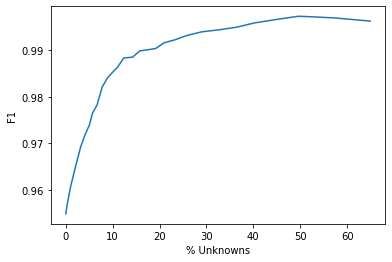

In [29]:
thresh = np.linspace(-2, 3, 50)
x = [100*(1-sum(margin > t)/len(margin)) for t in thresh]
y = [f1_score(test["topics"][margin > t], predicted[margin > t], average="macro") for t in thresh]
plt.plot(x, y)
plt.xlabel('% Unknowns')
plt.ylabel('F1')

In [30]:
print(classification_report(test["topics"][margin > 1.75], predicted[margin > 1.75]))

              precision    recall  f1-score   support

        GJOB       1.00      0.99      0.99       423
        GPOL       0.99      0.99      0.99      1438
        GSPO       1.00      1.00      1.00      1303
        GVIO       0.98      0.98      0.98       624

    accuracy                           0.99      3788
   macro avg       0.99      0.99      0.99      3788
weighted avg       0.99      0.99      0.99      3788



**TO DO:** Summarize your results for this section. What could we do if we wanted to make label as many examples as possible while still keeping F1 above 0.99?

We could exclude 20% of the articles used for classification, as the graph above tells us that anything 20% lower than the unknowns are smaller than the f1-scores. And the articles that are lower than the f1-scores can be classified by humans to do the labeling work as the computer is going to be accurate on labels with high f1-scores. In addition to that, we could also try considering changing the margins as it could possibly reduce the percentage of the unknowns based on the graph as margins determine how many articles we should exclude by choosing the amount of filter to be put in place.

---

## Model parameters

In [31]:
coef = sgd.named_steps['sgdclassifier'].coef_
labels, coef

(array(['GJOB', 'GPOL', 'GSPO', 'GVIO'], dtype='<U4'),
 array([[-0.26937097, -0.01556053,  0.1348538 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.35183383, -0.11800598, -0.04930472, ...,  0.00283071,
          0.        ,  0.00542061],
        [ 0.08043354,  0.05052013,  0.00922318, ...,  0.        ,
          0.        , -0.00550877],
        [-0.28388856,  0.        ,  0.03319324, ...,  0.        ,
          0.        , -0.01448666]]))

In [32]:
coef.shape

(4, 27939)

In [33]:
vocab = sgd.named_steps['countvectorizer'].get_feature_names()

In [34]:
coef[0,:].argmax()

13100

In [35]:
coef[0,13100]

4.538826464597272

In [36]:
vocab[13100]

'jobs'

In [37]:
ranked = np.argsort(coef, axis=1)
for i, label in enumerate(labels):
    print(label)
    for j in concat([range(-1, -11, -1), range(10, 0, -1)]):
        print(f'  {vocab[ranked[i,j]]:15s} {coef[i, ranked[i,j]]:6.3f}')
    print()

GJOB
  jobs             4.539
  strike           4.285
  employees        3.853
  workers          3.729
  unemployment     3.675
  company          2.742
  union            2.643
  unions           2.574
  wages            2.427
  wage             2.403
  welfare         -0.986
  political       -0.989
  parliament      -1.056
  war             -1.073
  clinton         -1.115
  spending        -1.119
  tax             -1.208
  security        -1.274
  budget          -1.471
  election        -1.737

GPOL
  election         3.783
  party            3.159
  elections        2.983
  parliament       2.829
  minister         2.815
  president        2.611
  vote             2.500
  budget           2.210
  clinton          2.064
  yeltsin          1.948
  union           -2.158
  rebels          -2.209
  bombing         -2.254
  strike          -2.489
  unions          -2.563
  employees       -2.567
  soccer          -2.682
  protest         -2.929
  workers         -3.166
  unemployment

In [38]:
from kwic import kwic

In [39]:
kwic('newsroom', train['text'])

4,l Amendment would appear on the state ballot next year. ((-- San Francisco,newsroom,", 415-677-2511))"
5,be called but it need not necessarily result in a work stoppage. -- Warsaw,Newsroom,+48 22 653 9700
14,"0 tonnes) and wheat ship (9,125 tonnes) --Caroline Bulloch, Rio de Janeiro",newsroom,", 5521 5074151"
15,the top tax rate and proposed taxes on night- and holiday shifts. -- Bonn,newsroom,", 49-228-26097150"
21,"t had so far sought to put the new law into effect. --Mark John, Frankfurt",Newsroom,+49 69 756525
37,"p of the conservative New Democracy party. --Dimitris Kontogiannis, Athens",Newsroom,+301 3311812-4
52,saying they would vote compared to 64.6 percent of CSSD voters. -- Prague,Newsroom,42-2-2423-0003
56,nment and a widepread perception that bureaucrats were corrupt. -- Vilnius,newsroom,", +370 2 22 35 17"
76,"on on the person likely to replace Malakis. --George Georgiopoulos, Athens",Newsroom,+301 3311812-4
83,"A promise without a cost is nearly always a lie."" -- Mike Peacock, London",Newsroom,+44 171 542 5109


In [40]:
kwic('zaire', train['text'])

32,rebels assure mining firms of continuity. Rebels on the advance in eastern,Zaire,"will leave mining concessions untouched in the areas they control, provide"
33,"Kabila, Mobutu agree to",Zaire,talks Wednesday - UN. Zaire's beleaguered president Mobutu Sese Seko and r
33,"Kabila, Mobutu agree to Zaire talks Wednesday - UN.",Zaire,'s beleaguered president Mobutu Sese Seko and rebel leader Laurent Kabila h
33,rt of a South African attempt to mediate a peaceful transition of power in,Zaire,. Kabila's rebels now control three quarters of the country and Mobutu has
38,ops who were trapped at the airport and had threatening to rain rockets on,Zaire,"'s second city. A day after the rebel takeover, residents looted army premi"
38,in on from all sides. Disciplined columns of Kabila's forces marched into,Zaire,'s copper capital and economic powerhouse on Wednesday morning. The army la
86,S.Africa to host,Zaire,"government, rebels for talks. Zaire's warring sides have asked President N"
86,"S.Africa to host Zaire government, rebels for talks.",Zaire,'s warring sides have asked President Nelson Mandela of South Africa to hos
86,"s,"" Mandela said. He said South Africa would send air transport to pick up",Zaire,'s rebel leader Laurent Kabila from Kigali in Rwanda and that he hoped the
86,s in Cape Town with regional leaders on how to defuse growing conflicts in,Zaire,"and in southern Africa. Fighting in Zaire has intensified, with ailing Pre"


**TO DO:** What can you conclude about the model from looking at the coefficients? Is there evidence of overfitting? How could we improve the results?

We can conclude from looking at the coefficients that the model is dependent on the labeling of articles by specific unique words that occur within in these articles, and use some kind of measure to classify the word itself with other words that have been already classified. One example of this is with the word "bombing" in the context of violence, as it has a negative connotation as an act of violence to classify the article as "violence". Conversely, the word "soccer" is considerd a neutral word for it to not classify the article as "violence". 

There is evidence of overfitting in the form of the name "Clinton", as it's not a word that's normally associated with politics, but rather the name of famous political figures being mentioned in these articles where politics is part of their career. It would seem that the coefficients for the name "Clinton" is high as well in articles labeled politics.
One way to improve the results, would be to exclude "overtraining" words that would label articles with unusual circumstances. For example, excluding the word "Zaire", as it's a word that is normally associated with violence since it's a country dealing with war due to totalitarian military government.